In [13]:
import os
import numpy as np
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import cv2

import os
import sys
sys.path.append('/zhome/65/e/156416/E24/IDLCV/Detection_deeplearning_in_computervision')  

from frednet import PotholeDataset, plot_image_with_bboxes

In [14]:
data_path = '/zhome/65/e/156416/E24/IDLCV/Detection_deeplearning_in_computervision/Potholes/Potholes/annotated-images/'

dataset = PotholeDataset(data_path)
print(f"Loaded {len(dataset)} images with annotations.")
image, annotation = dataset[0]
print("Image shape:", image.shape)
print("Annotation:", annotation)

Loaded 665 images with annotations.
Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


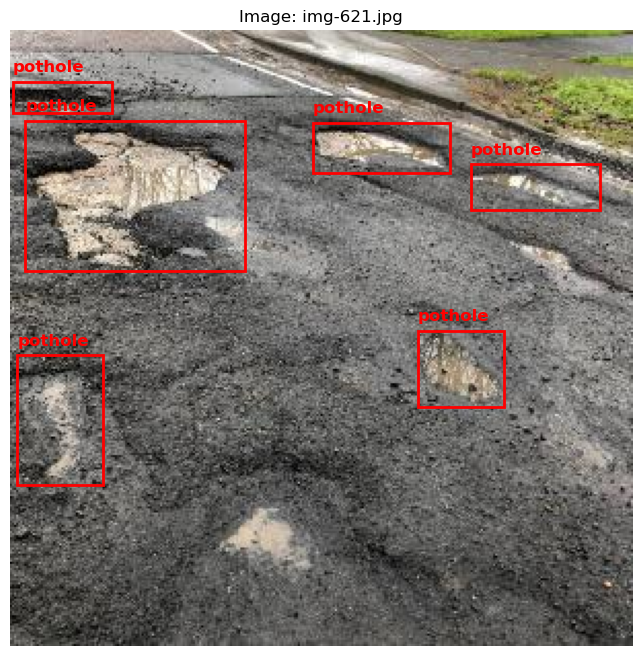

In [15]:
#Plot the first 5 images with their bounding boxes
for idx in range(1):
    image, annotation = dataset[idx]
    print(f"Image shape: {image.shape}")
    print(f"Annotation: {annotation}")
    plot_image_with_bboxes(image, annotation)

In [ ]:
import cv2
import numpy as np
import os

def extract_edge_boxes(image, model_path='/zhome/65/e/156416/E24/IDLCV/Detection_deeplearning_in_computervision/model.yml.gz', max_boxes=100, alpha=0.65, beta=0.75):
    # Load the pre-trained edge detection model
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model_path)
    
    # Convert image to RGB as the model expects RGB images
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect edges and compute orientation map
    edges = edge_detection.detectEdges(np.float32(rgb_image) / 255.0)
    orientation_map = edge_detection.computeOrientation(edges)
    
    # Create Edge Boxes object
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_boxes)
    edge_boxes.setAlpha(alpha)
    edge_boxes.setBeta(beta)
    
    # Get bounding boxes
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)
    return boxes, scores

Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


Extracted 50 edge boxes


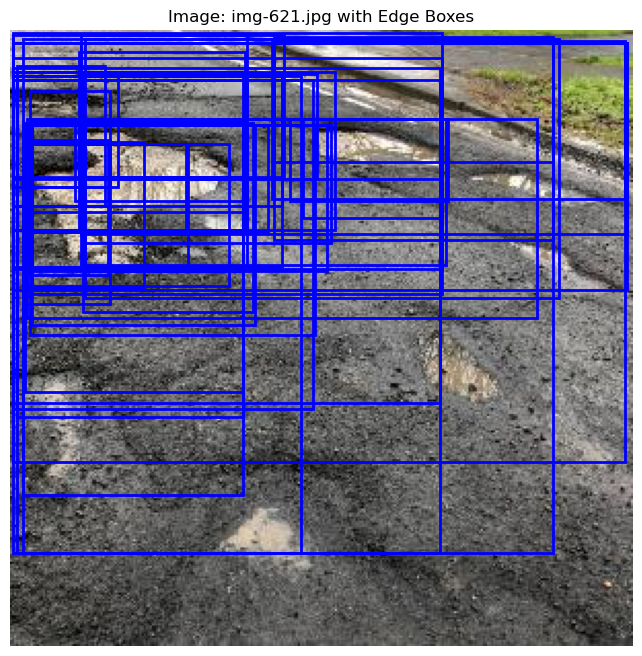

Image shape: (300, 480, 3)
Annotation: {'filename': 'img-577.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-577.jpg', 'size': {'width': 480, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 37, 'ymin': 154, 'xmax': 235, 'ymax': 234}}, {'name': 'pothole', 'bndbox': {'xmin': 104, 'ymin': 120, 'xmax': 141, 'ymax': 132}}, {'name': 'pothole', 'bndbox': {'xmin': 35, 'ymin': 241, 'xmax': 96, 'ymax': 300}}, {'name': 'pothole', 'bndbox': {'xmin': 274, 'ymin': 194, 'xmax': 342, 'ymax': 237}}, {'name': 'pothole', 'bndbox': {'xmin': 313, 'ymin': 242, 'xmax': 354, 'ymax': 283}}, {'name': 'pothole', 'bndbox': {'xmin': 361, 'ymin': 227, 'xmax': 419, 'ymax': 270}}, {'name': 'pothole', 'bndbox': {'xmin': 359, 'ymin': 182, 'xmax': 437, 'ymax': 218}}, {'name': 'pothole', 'bndbox': {'xmin': 366, 'ymin': 146, 'xmax': 479, 'ymax': 189}}, {'name': 'pothole', 'bndbox': {'xmin': 322, 'ymin': 126, 'xmax': 363, 'ymax': 150}}, {'name': 'pothole', 'bndbox': {'xmin': 339, 'ymin'

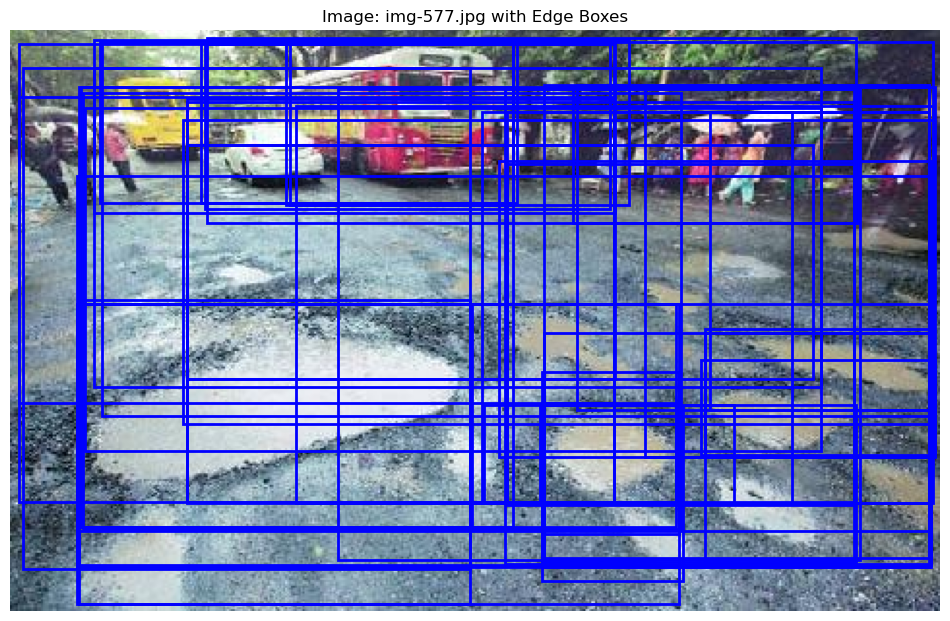

Image shape: (300, 400, 3)
Annotation: {'filename': 'img-338.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-338.jpg', 'size': {'width': 400, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 62, 'ymin': 74, 'xmax': 370, 'ymax': 257}}]}
Extracted 50 edge boxes


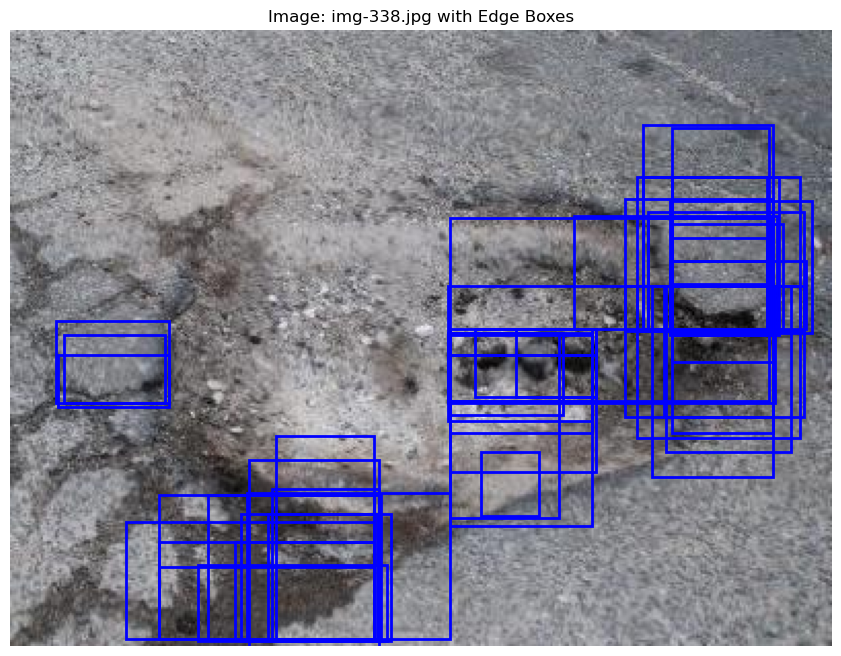

Image shape: (300, 400, 3)
Annotation: {'filename': 'img-561.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-561.jpg', 'size': {'width': 400, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 176, 'ymin': 38, 'xmax': 212, 'ymax': 52}}, {'name': 'pothole', 'bndbox': {'xmin': 190, 'ymin': 5, 'xmax': 247, 'ymax': 25}}, {'name': 'pothole', 'bndbox': {'xmin': 279, 'ymin': 1, 'xmax': 400, 'ymax': 161}}, {'name': 'pothole', 'bndbox': {'xmin': 20, 'ymin': 87, 'xmax': 298, 'ymax': 191}}, {'name': 'pothole', 'bndbox': {'xmin': 61, 'ymin': 201, 'xmax': 179, 'ymax': 300}}, {'name': 'pothole', 'bndbox': {'xmin': 2, 'ymin': 231, 'xmax': 44, 'ymax': 255}}, {'name': 'pothole', 'bndbox': {'xmin': 163, 'ymin': 57, 'xmax': 191, 'ymax': 76}}, {'name': 'pothole', 'bndbox': {'xmin': 124, 'ymin': 70, 'xmax': 160, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 339, 'ymin': 163, 'xmax': 400, 'ymax': 193}}]}
Extracted 50 edge boxes


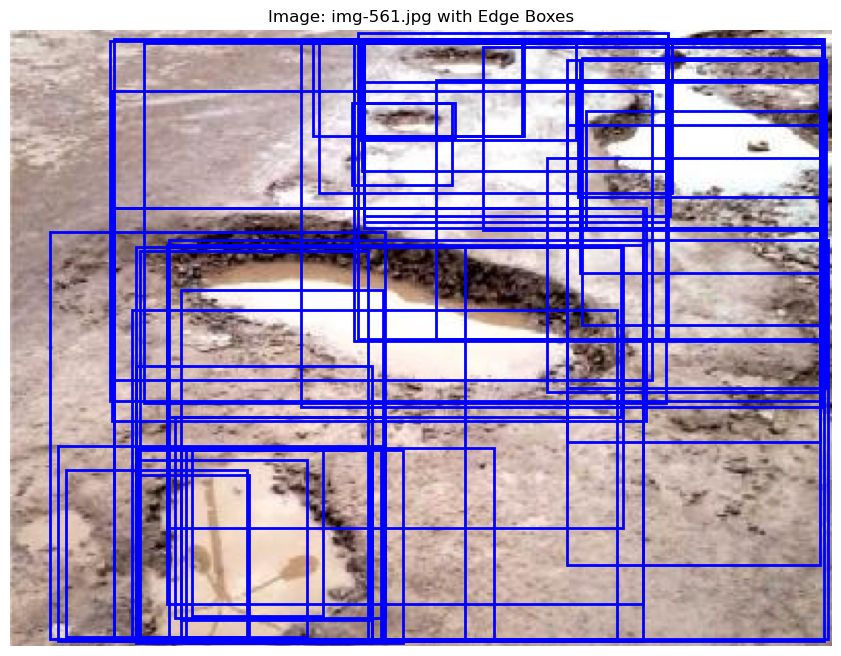

Image shape: (300, 455, 3)
Annotation: {'filename': 'img-455.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-455.jpg', 'size': {'width': 455, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 266, 'ymin': 109, 'xmax': 323, 'ymax': 138}}]}
Extracted 50 edge boxes


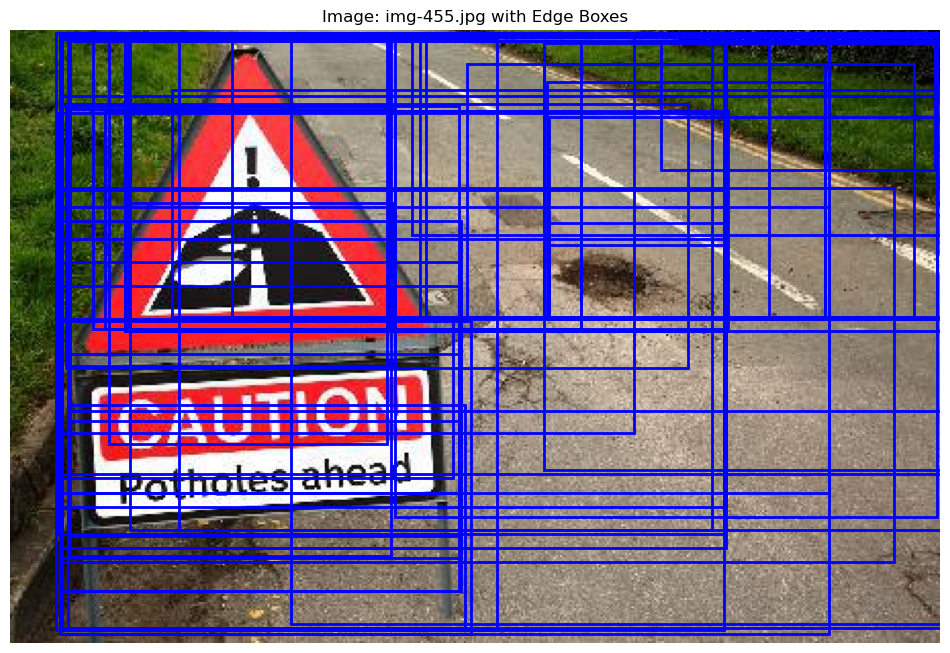

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for idx in range(5):  # Adjust the range as needed
    image, annotation = dataset[idx]
    print(f"Image shape: {image.shape}")
    print(f"Annotation: {annotation}")

    boxes, scores = extract_edge_boxes(image)
    print(f"Extracted {len(boxes)} edge boxes")

    # Plot image with edge boxes
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    plt.title(f"Image: {annotation['filename']} with Edge Boxes")
    plt.axis('off')
    plt.show()

In [ ]:
def evaluate_proposals(dataset, iou_threshold=0.5):
    total_proposals = 0
    total_images = len(dataset)
    
    for idx in range(total_images):
        image, annotation = dataset[idx]
        boxes, scores = extract_edge_boxes(image)
        
        # Evaluate proposals
        required_proposals = 0
        for box in boxes:
            x, y, w, h = box
            proposal_area = w * h
            
            for obj in annotation['objects']:
                if 'bbox' in obj:
                    gt_x, gt_y, gt_w, gt_h = obj['bbox']
                    gt_area = gt_w * gt_h
                    
                    # Calculate IoU
                    inter_x1 = max(x, gt_x)
                    inter_y1 = max(y, gt_y)
                    inter_x2 = min(x + w, gt_x + gt_w)
                    inter_y2 = min(y + h, gt_y + gt_h)
                    
                    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
                    union_area = proposal_area + gt_area - inter_area
                    
                    iou = inter_area / union_area
                    
                    if iou >= iou_threshold:
                        required_proposals += 1
                        break
        
        total_proposals += required_proposals
    
    avg_proposals = total_proposals / total_images
    return avg_proposals

# Evaluate proposals on the training set
average_proposals = evaluate_proposals(dataset)
print(f"Average number of required proposals: {average_proposals}")